In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'kidney_binary'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/kidney_cancer_with_celltypes.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_binary')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

gene_col = 'gene_symbols'
batch_col = 'sample'
label_col = 'cell_type'
layer_key = 'X'

RUN_TAG = 'binary'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V2-104M_CLcancer').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/kidney_cancer_with_celltypes.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 4
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-12 05:30:29 | Using device cuda
INFO     | 2025-08-12 05:30:29 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V2-104M_CLcancer


In [5]:
# Inspect dataset and derive binary labels
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

# Show the actual cell types first
print('\nOriginal cell types:')
print(ad.obs[label_col].value_counts())

# Create binary labels - Malignant vs Non-malignant
label_series = ad.obs[label_col].astype(str)

# Simple and direct approach: Malignant = Malignant, everything else = Non-malignant
positive_mask = label_series == 'Malignant'
ad.obs['binary_label'] = np.where(positive_mask, 'Malignant', 'Non-malignant')

print('\nBinary label distribution:')
print(ad.obs['binary_label'].value_counts())

# Verify the mapping worked correctly
print('\nVerification:')
print('Original Malignant cells:', (label_series == 'Malignant').sum())
print('Binary Malignant cells:', (ad.obs['binary_label'] == 'Malignant').sum())
print('Original Non-malignant cells:', (label_series != 'Malignant').sum())
print('Binary Non-malignant cells:', (ad.obs['binary_label'] == 'Non-malignant').sum())

# Check for any NaN values and handle them
if ad.obs['binary_label'].isna().any():
    print(f"\nWARNING: Found {ad.obs['binary_label'].isna().sum()} NaN values in binary_label")
    # Remove NaN values
    ad = ad[ad.obs['binary_label'].notna()].copy()
    print(f"Removed NaN values. New shape: {ad.shape}")

_tmp = preprocessed_path / f'{dataset_name}_with_binary.h5ad'
ad.write(_tmp)
print('\nWrote:', _tmp)

... storing 'binary_label' as categorical


adata shape: (19781, 19234)
obs columns: ['cell_name', 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'source', 'clusters_by_authors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes']
var columns: ['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbols']
label_col -> cell_type
batch_col -> sample

Original cell types:
cell_type
Malignant      9369
Fibroblast     4012
Endothelial    3633
Macrophage     1603
Epithelial      749
Name: count, dtype: int64

Binary label distribution:
binary_label
Non-malignant    10412
Malignant         9369
Name: count, dtype: int64

Verification:
Original Malignant cells: 9369
Binary Malignant cells: 9369
Original Non-maligna

In [6]:
# After creating binary labels in Cell 5, add this:
label_col = 'binary_label'  # Update to use the new binary labels
print('Updated label_col ->', label_col)

Updated label_col -> binary_label


In [7]:
# Fix sparse matrix issues for preprocessing
import scanpy as sc
import numpy as np
import scipy.sparse

print("=== FIXING SPARSE MATRIX ISSUES ===")

# Load the data
ad = sc.read_h5ad(str(_tmp))
print(f"Original data shape: {ad.shape}")
print(f"Data type: {type(ad.X)}")

# Convert sparse matrix to dense for compatibility with the preprocessing pipeline
if scipy.sparse.issparse(ad.X):
    print("Converting sparse matrix to dense for compatibility...")
    print("This may take a moment for large datasets...")
    
    # Convert to dense matrix
    ad.X = ad.X.toarray()
    print(f"Converted to dense matrix. New type: {type(ad.X)}")
    print(f"Memory usage: {ad.X.nbytes / 1e9:.2f} GB")
    
    # Check for any issues after conversion
    print(f"Data range after conversion: {ad.X.min()} to {ad.X.max()}")
    print(f"Any NaN: {np.isnan(ad.X).any()}")
    print(f"Any Inf: {np.isinf(ad.X).any()}")

# Ensure all required columns exist
required_cols = ['n_genes_by_counts', 'total_counts', 'n_counts']
existing_cols = ad.obs.columns.tolist()

for col in required_cols:
    if col not in existing_cols:
        if col == 'n_genes_by_counts':
            # Calculate manually
            ad.obs[col] = (ad.X > 0).sum(axis=1)
            print(f"Added {col}: {ad.obs[col].shape}")
        elif col == 'total_counts':
            # Calculate manually
            ad.obs[col] = ad.X.sum(axis=1)
            print(f"Added {col}: {ad.obs[col].shape}")
        elif col == 'n_counts':
            # Copy from total_counts
            ad.obs[col] = ad.obs['total_counts']
            print(f"Added {col}: {ad.obs[col].shape}")

# Add log1p versions
if 'log1p_total_counts' not in existing_cols:
    ad.obs['log1p_total_counts'] = np.log1p(ad.obs['total_counts'])
if 'log1p_n_genes_by_counts' not in existing_cols:
    ad.obs['log1p_n_genes_by_counts'] = np.log1p(ad.obs['n_genes_by_counts'])

# ADD THIS: Create ensembl_id column for tokenization
if 'ensembl_id' not in ad.var.columns:
    # Use the gene symbols as ensembl_id (or create a mapping)
    if 'gene_symbols' in ad.var.columns:
        ad.var['ensembl_id'] = ad.var['gene_symbols']
        print("Created ensembl_id from gene_symbols")
    else:
        # Use the index as ensembl_id
        ad.var['ensembl_id'] = ad.var.index.astype(str)
        print("Created ensembl_id from index")

print(f"\nFinal obs columns: {ad.obs.columns.tolist()}")
print(f"Final var columns: {ad.var.columns.tolist()}")
print(f"Final data shape: {ad.shape}")

# Save the fixed data
_tmp_fixed = preprocessed_path / f'{dataset_name}_with_binary_fixed.h5ad'
ad.write(_tmp_fixed)
print(f"\nSaved fixed data to: {_tmp_fixed}")

# Update the path for the next steps
_tmp = _tmp_fixed

=== FIXING SPARSE MATRIX ISSUES ===
Original data shape: (19781, 19234)
Data type: <class 'scipy.sparse._csc.csc_matrix'>
Converting sparse matrix to dense for compatibility...
This may take a moment for large datasets...
Converted to dense matrix. New type: <class 'numpy.ndarray'>
Memory usage: 3.04 GB
Data range after conversion: 0 to 3596
Any NaN: False
Any Inf: False
Added n_counts: (19781,)
Created ensembl_id from gene_symbols

Final obs columns: ['cell_name', 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'source', 'clusters_by_authors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'binary_label', 'n_counts']
Final var columns: ['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [8]:
# Use automatic preprocessing
print(f"Using data: {_tmp}")

# Create InputData and run automatic preprocessing
print("Using automatic preprocessing...")
inp = data.InputData(adata_dataset_path=str(_tmp))
print(f"Created InputData object: {type(inp)}")
print(f"InputData adata shape: {inp.adata.shape}")
print(f"Binary labels in InputData: {inp.adata.obs['binary_label'].value_counts()}")

try:
    print("Starting automatic preprocessing...")
    inp.preprocess_data(
        gene_col='gene_symbols',
        model_type='geneformer',
        save_ext='h5ad',
        gene_name_id_dict=geneform.gene_name_id,
        preprocessed_path=str(preprocessed_path),
        fract_matching=0.1
    )
    h5_stem = Path(_tmp).stem
    h5_path = preprocessed_path / f'{h5_stem}.h5ad'
    print("Automatic preprocessing successful!")
    print(f"Preprocessed file saved to: {h5_path}")
    
    # FIX: Restore the ensembl_id column that was lost during preprocessing
    print("Restoring ensembl_id column...")
    ad_restored = sc.read(str(h5_path))
    if 'ensembl_id' not in ad_restored.var.columns:
        if 'gene_symbols' in ad_restored.var.columns:
            ad_restored.var['ensembl_id'] = ad_restored.var['gene_symbols']
            print("Restored ensembl_id from gene_symbols")
        else:
            ad_restored.var['ensembl_id'] = ad_restored.var.index.astype(str)
            print("Restored ensembl_id from index")
        ad_restored.write(str(h5_path))
        print("Updated preprocessed file with ensembl_id column")
    
except Exception as e:
    print(f"Automatic preprocessing failed: {e}")
    print("Check the error above and fix the issue")
    raise e

print(f'Final h5_path: {h5_path}, exists: {h5_path.exists()}')

INFO     | 2025-08-12 05:31:11 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad


Using data: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad
Using automatic preprocessing...
Created InputData object: <class 'sc_foundation_evals.data.InputData'>
InputData adata shape: (19781, 19234)
Binary labels in InputData: binary_label
Non-malignant    10412
Malignant         9369
Name: count, dtype: int64
Starting automatic preprocessing...


INFO     | 2025-08-12 05:32:43 | Matched 87.41% genes (14547/16643) genes in vocabulary of size 63675.


Automatic preprocessing successful!
Preprocessed file saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad
Restoring ensembl_id column...
Final h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad, exists: True


In [9]:
# Verify/update columns required for tokenization
import scanpy as sc
pfile = str(h5_path)

ad_tmp = sc.read(pfile)
if 'binary_label' not in ad_tmp.obs.columns:
    raise ValueError('binary_label missing in preprocessed file')
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values
ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad


In [10]:
# Skip preprocessing and use the fixed file directly
print(f"Using fixed file directly: {_tmp}")
h5_path = _tmp  # Use the fixed file as-is
print(f"h5_path: {h5_path}, exists: {h5_path.exists()}")

Using fixed file directly: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad
h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad, exists: True


In [11]:
# FIX: Create a separate directory with only our target file to avoid glob confusion
import shutil
import glob
import os
from datetime import datetime

# First, let's see what files exist
print("=== CHECKING ACTUAL FILES ===")
print(f"Directory: {preprocessed_path}")
h5ad_files = glob.glob(str(preprocessed_path / "*.h5ad"))
print(f"All h5ad files: {[os.path.basename(f) for f in h5ad_files]}")

# Create the fixed file path
fixed_file_path = preprocessed_path / f'{dataset_name}_with_binary_fixed.h5ad'
print(f"Original fixed file: {fixed_file_path}")
print(f"File exists: {fixed_file_path.exists()}")

# Create a SEPARATE directory with ONLY our target file to avoid glob confusion
tokenize_dir = preprocessed_path / 'tokenize_only'
tokenize_dir.mkdir(exist_ok=True)

# Copy the fixed file to the separate directory with a simple name
target_file_name = f'{dataset_name}_binary.h5ad'
target_file_path = tokenize_dir / target_file_name

if fixed_file_path.exists():
    shutil.copy2(str(fixed_file_path), str(target_file_path))
    print(f"Copied to isolated directory: {target_file_path}")
else:
    print("❌ ERROR: Fixed file doesn't exist!")
    raise FileNotFoundError(f"Fixed file not found: {fixed_file_path}")

# Verify the target file has the right columns
print("\n=== VERIFYING TARGET FILE ===")
ad_target = sc.read(str(target_file_path))
print(f"Target file shape: {ad_target.shape}")
print(f"ensembl_id in target file: {'ensembl_id' in ad_target.var.columns}")
print(f"binary_label in target file: {'binary_label' in ad_target.obs.columns}")
if 'ensembl_id' in ad_target.var.columns:
    print(f"ensembl_id first few: {ad_target.var['ensembl_id'].head().tolist()}")
if 'binary_label' in ad_target.obs.columns:
    print(f"binary_label counts: {ad_target.obs['binary_label'].value_counts().to_dict()}")

# Check directory contents
print(f"\nFiles in tokenize directory: {list(tokenize_dir.glob('*.h5ad'))}")

# Now try tokenization with the isolated file
print("\n=== STARTING TOKENIZATION ===")
print(f"Tokenizing from directory: {tokenize_dir}")
print(f"Target file: {target_file_path}")

geneform.tokenize_data(
    adata_path=str(target_file_path),
    dataset_path=str(preprocessed_path),
    cell_type_col='binary_label'
)

dataset_dir = preprocessed_path / f'{dataset_name}_binary.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name + '_binary',
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': 'binary_label',
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_binary.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}_binary.dataset')
print('Archived tokenized dataset to:', archive_path)

# Clean up the isolated directory after successful tokenization
try:
    shutil.rmtree(str(tokenize_dir))
    print(f"Cleaned up tokenize directory: {tokenize_dir}")
except:
    print(f"Could not clean up tokenize directory: {tokenize_dir}")


=== CHECKING ACTUAL FILES ===
Directory: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary
All h5ad files: ['kidney_cancer_with_celltypes_with_binary.h5ad', 'kidney_cancer_with_celltypes_with_binary_fixed.h5ad', 'UNIQUE_FIXED_kidney_cancer_with_celltypes_binary.h5ad']
Original fixed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_with_binary_fixed.h5ad
File exists: True
Copied to isolated directory: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/tokenize_only/kidney_cancer_with_celltypes_binary.h5ad

=== VERIFYING TARGET FILE ===


WARNING  | 2025-08-12 05:34:56 | using h5ad file. This sometimes causes issues. If not working try with loom.


Target file shape: (19781, 14547)
ensembl_id in target file: True
binary_label in target file: True
ensembl_id first few: ['ENSG00000225880', 'ENSG00000230368', 'ENSG00000188976', 'ENSG00000188290', 'ENSG00000187608']
binary_label counts: {'Non-malignant': 10412, 'Malignant': 9369}

Files in tokenize directory: [PosixPath('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/tokenize_only/kidney_cancer_with_celltypes_binary.h5ad')]

=== STARTING TOKENIZATION ===
Tokenizing from directory: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/tokenize_only
Target file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/tokenize_only/kidney_cancer_with_celltypes_binary.h5ad
Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/tokenize_only/kidney_cancer_with_celltypes

Setting num_proc from 24 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_binary.dataset exists: True
save_to_disk skipped: Tried to overwrite /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_binary.dataset but a dataset can't overwrite itself.
Saved row_order.csv
Saved manifest.json
Archived tokenized dataset to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs/kidney_cancer_with_celltypes_binary.dataset.tar.gz
Cleaned up tokenize directory: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/tokenize_only


In [12]:
# Load back and extract embeddings (binary)
# Note: dataset_dir should be set after successful tokenization from previous cell

print(f"Looking for tokenized dataset at: {dataset_dir}")
if not dataset_dir.exists():
    print(f"⚠️ Dataset directory not found. Expected at: {dataset_dir}")
    print("Make sure tokenization completed successfully in the previous cell.")
    raise FileNotFoundError(f"Tokenized dataset not found at {dataset_dir}")

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key='binary_label',
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


Looking for tokenized dataset at: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/kidney_cancer_with_celltypes_binary/kidney_cancer_with_celltypes_binary.dataset


Geneformer (extracting embeddings): 100%|██████████| 4946/4946 [18:00<00:00,  4.58it/s]
DEBUG    | 2025-08-12 05:56:11 | Extracting output from 500 cells
WARNING  | 2025-08-12 05:56:19 | adata_ has 19781 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-12 05:56:19 | Computing metrics for binary_label
DEBUG    | 2025-08-12 05:56:23 | NMI_cluster/label: 0.5541
ARI_cluster/label: 0.5539
ASW_label: 0.5435
graph_conn: 1.0000
ASW_batch: 0.4895
ASW_label/batch: 0.8825
PCR_batch: 0.1956
avg_bio: 0.5505
DEBUG    | 2025-08-12 05:56:23 | NMI_cluster/label for binary_label: 0.5540824716283833
DEBUG    | 2025-08-12 05:56:23 | ARI_cluster/label for binary_label: 0.5539183630137603
DEBUG    | 2025-08-12 05:56:23 | ASW_label for binary_label: 0.5434688925743103
DEBUG    | 2025-08-12 05:56:23 | graph_conn for binary_label: 1.0
DEBUG    | 2025-08-12 05:56:23 | ASW_batch for binary_label: 0.4895225465297699
DEBUG    | 2025-08-12 05:56:23 | ASW_label/batch for binary_label: 0.882477879524231
DEBUG

,metric,label,value
0,NMI_cluster/label,binary_label,0.554082
1,ARI_cluster/label,binary_label,0.553918
2,ASW_label,binary_label,0.543469
3,graph_conn,binary_label,1.000000
4,ASW_batch,binary_label,0.489523
5,ASW_label/batch,binary_label,0.882478
6,PCR_batch,binary_label,0.195645
7,avg_bio,binary_label,0.550490


In [13]:
# Check what's available in the evaluation object
print("Available attributes:", dir(eval_ce))
print("Available obs columns:", eval_ce.data.adata.obs.columns.tolist())

# Check if embeddings exist
print("Available embeddings:", list(eval_ce.data.adata.obsm.keys()))

# Check the label column that was specified during initialization
print("Label columns specified:", eval_ce.label_key)

Available attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_wandb', 'batch_key', 'create_original_umap', 'data', 'eval_instance', 'evaluate', 'label_key', 'output_dir', 'visualize']
Available obs columns: ['cell_name', 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'source', 'clusters_by_authors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'binary_label', 'n_counts'

In [14]:
# Check embedding quality
embeddings = eval_ce.data.adata.obsm['geneformer']
print(f"Embedding shape: {embeddings.shape}")
print(f"Embedding dtype: {embeddings.dtype}")
print(f"Any NaN in embeddings: {np.isnan(embeddings).any()}")
print(f"Any Inf in embeddings: {np.isinf(embeddings).any()}")

# Check label quality
labels = eval_ce.data.adata.obs['binary_label']
print(f"Label dtype: {labels.dtype}")
print(f"Label unique values: {labels.unique()}")
print(f"Any NaN in labels: {labels.isna().any()}")

# Check if batch key exists and is valid
if hasattr(eval_ce, 'batch_key') and eval_ce.batch_key:
    batch_col = eval_ce.batch_key
    print(f"Batch column: {batch_col}")
    if batch_col in eval_ce.data.adata.obs.columns:
        batch_vals = eval_ce.data.adata.obs[batch_col]
        print(f"Batch unique values: {batch_vals.unique()}")
        print(f"Any NaN in batch: {batch_vals.isna().any()}")
    else:
        print(f"Batch column '{batch_col}' not found in obs")

Embedding shape: (19781, 768)
Embedding dtype: float32
Any NaN in embeddings: False
Any Inf in embeddings: False
Label dtype: category
Label unique values: ['Non-malignant', 'Malignant']
Categories (2, object): ['Malignant', 'Non-malignant']
Any NaN in labels: False
Batch column: sample
Batch unique values: ['Patient1', 'Patient2', 'Patient3', 'Patient4', 'Patient5', 'Patient6', 'Patient7', 'Patient8']
Categories (8, object): ['Patient1', 'Patient2', 'Patient3', 'Patient4', 'Patient5', 'Patient6', 'Patient7', 'Patient8']
Any NaN in batch: False


In [15]:
# Ensemble evaluation and saving (binary)
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col='binary_label',
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.5, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name + '_binary',
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_kidney_binary_results_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_kidney_binary_metrics_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-12 05:56:23 | Initialized GeneformerEnsembleMetrics with 19781 cells and 2 classes
INFO     | 2025-08-12 05:56:23 | Classes: ['Malignant', 'Non-malignant']
INFO     | 2025-08-12 05:56:23 | Embedding shape: (19781, 768)
INFO     | 2025-08-12 05:56:23 | Input rankings length: 19781
INFO     | 2025-08-12 05:56:23 | Output rankings length: 19781
INFO     | 2025-08-12 05:56:23 | Evaluated embedding_only (α=0.0): Accuracy=0.866, F1=0.866, AUC-ROC=0.699
INFO     | 2025-08-12 05:56:23 | Evaluated embedding_only (α=0.5): Accuracy=0.866, F1=0.866, AUC-ROC=0.699
INFO     | 2025-08-12 05:56:23 | Evaluated embedding_only (α=1.0): Accuracy=0.866, F1=0.866, AUC-ROC=0.699


alpha=0.0: F1=0.866, AUC=0.699, Acc=0.866
alpha=0.5: F1=0.866, AUC=0.699, Acc=0.866
alpha=1.0: F1=0.866, AUC=0.699, Acc=0.866
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs/geneformer_kidney_binary_results_binary.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs/geneformer_kidney_binary_metrics_binary.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs/geneformer_kidney_binary_confusion_matrix_binary.png


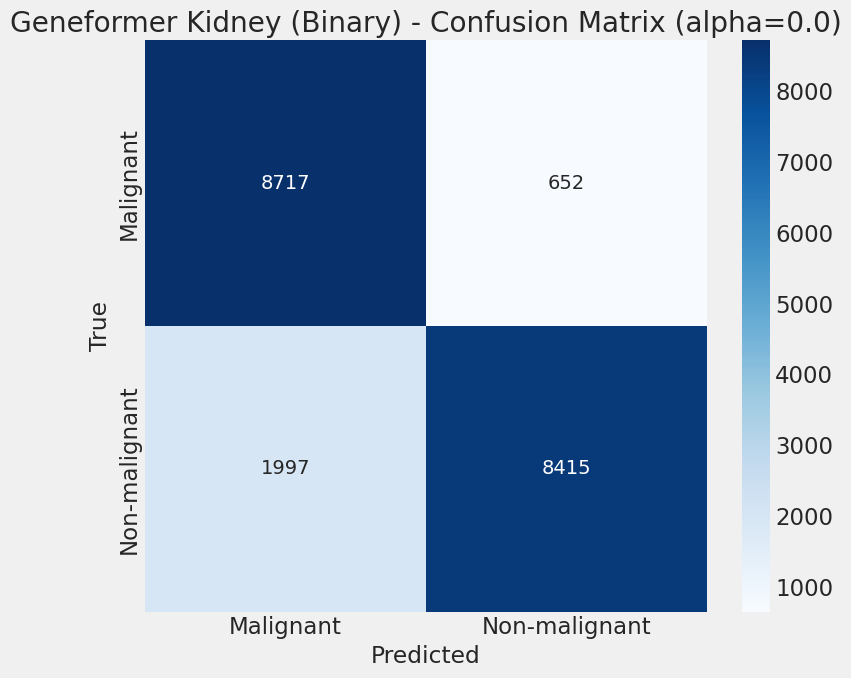

In [16]:
# Confusion matrix (binary)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(8, 7))
xtl = ytl = list(em.class_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xtl, yticklabels=ytl, ax=ax)
ax.set_title(f'Geneformer Kidney (Binary) - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_kidney_binary_confusion_matrix_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs/geneformer_kidney_binary_umap_coords_binary.csv


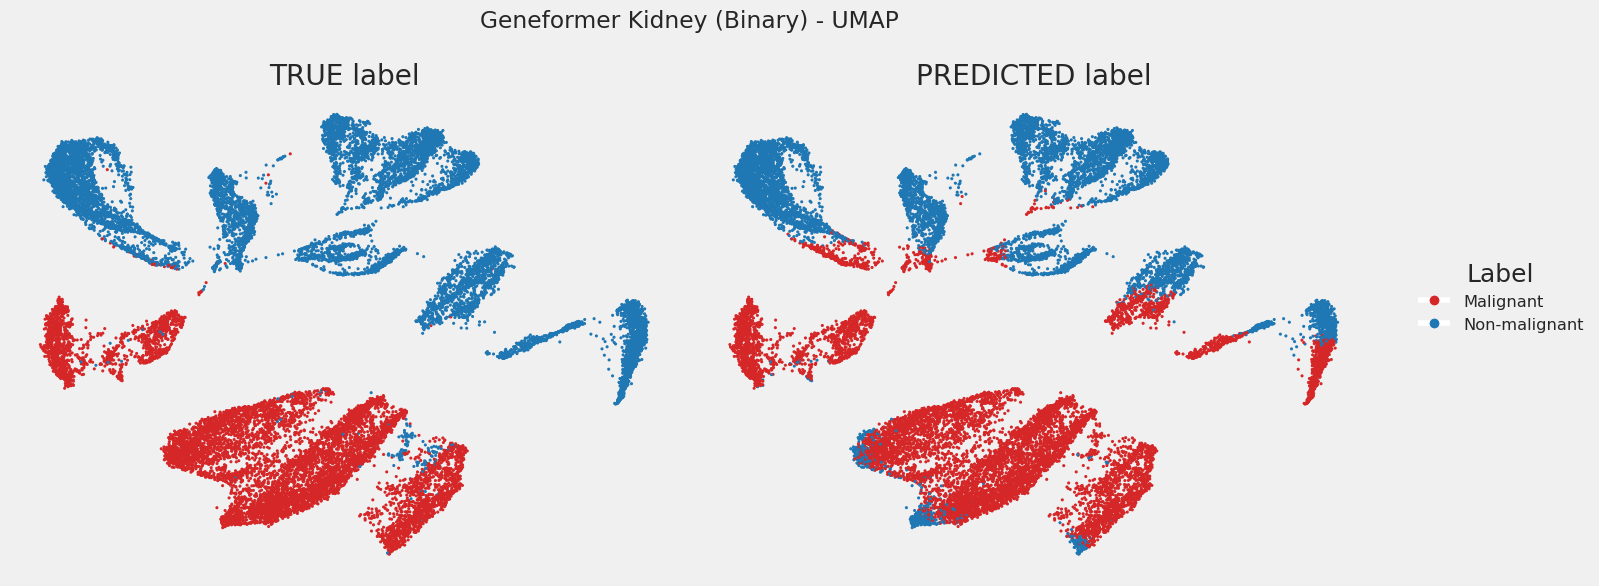

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs/geneformer_kidney_binary_umap_true_pred_with_legend_binary.png


In [17]:
# UMAP of binary labels
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
preds_arr = np.asarray(preds)
class_names = list(em.class_names)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

if set(class_names) == {'Malignant', 'Non-malignant'}:
    palette = {'Non-malignant': '#1f77b4', 'Malignant': '#d62728'}
else:
    palette = dict(zip(class_names, sns.color_palette('tab10', n_colors=len(class_names))))

coords_path = MODEL_OUT / f'geneformer_kidney_binary_umap_coords_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE label'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED label'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small', title='Label')
fig.suptitle(f'Geneformer Kidney (Binary) - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_kidney_binary_umap_true_pred_with_legend_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Debug: Check what the ensemble evaluation actually used
print("=== ENSEMBLE EVALUATION DEBUG - KIDNEY MALIGNANCY ===")
print(f"Ensemble embeddings shape: {em.embeddings.shape}")
print(f"Ensemble labels shape: {em.labels_encoded.shape}")
print(f"Ensemble predictions shape: {preds.shape}")
print(f"Ensemble class names: {em.class_names}")

# Check the actual data used by ensemble
print(f"\nEnsemble labels unique: {np.unique(em.labels_encoded)}")
print(f"Ensemble predictions unique: {np.unique(preds)}")

# Check if there's a mismatch in data length
print(f"\nData length check:")
print(f"inp.adata shape: {inp.adata.shape}")
print(f"em.embeddings length: {len(em.embeddings)}")
print(f"em.labels_encoded length: {len(em.labels_encoded)}")
print(f"preds length: {len(preds)}")

# Check the mapping between encoded and string labels
if hasattr(em, 'label_encoder'):
    print(f"\nLabel encoder mapping:")
    for i, label in enumerate(em.class_names):
        print(f"  {i} -> {label}")

# Use the ensemble's actual data for consistent results
print("\n=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===")

# Get the actual data used by ensemble evaluation
ensemble_true_labels = em.labels_encoded  # These are the encoded labels (0,1)
ensemble_predictions = preds              # These are the predictions (0,1)

print(f"Ensemble true labels: {np.unique(ensemble_true_labels)}")
print(f"Ensemble predictions: {np.unique(ensemble_predictions)}")

# Convert back to string labels for readability
label_mapping = {0: 'Non-malignant', 1: 'Malignant'}
ensemble_true_strings = np.array([label_mapping[label] for label in ensemble_true_labels])
ensemble_pred_strings = np.array([label_mapping[label] for label in ensemble_predictions])

print(f"Ensemble true strings: {np.unique(ensemble_true_strings)}")
print(f"Ensemble pred strings: {np.unique(ensemble_pred_strings)}")

# Now calculate metrics using ensemble data
print("\n=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===")
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

# Calculate metrics
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=1,  # 1 = Malignant
                                                         zero_division=0)

print(f"\nMetrics using ensemble data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# These should match the ensemble evaluation results!

=== ENSEMBLE EVALUATION DEBUG - KIDNEY MALIGNANCY ===
Ensemble embeddings shape: (19781, 768)
Ensemble labels shape: (19781,)
Ensemble predictions shape: (19781,)
Ensemble class names: ['Malignant' 'Non-malignant']

Ensemble labels unique: [0 1]
Ensemble predictions unique: [0 1]

Data length check:
inp.adata shape: (19781, 14547)
em.embeddings length: 19781
em.labels_encoded length: 19781
preds length: 19781

Label encoder mapping:
  0 -> Malignant
  1 -> Non-malignant

=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===
Ensemble true labels: [0 1]
Ensemble predictions: [0 1]
Ensemble true strings: ['Malignant' 'Non-malignant']
Ensemble pred strings: ['Malignant' 'Non-malignant']

=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===
               precision    recall  f1-score   support

Non-malignant     0.9281    0.8082    0.8640     10412
    Malignant     0.8136    0.9304    0.8681      9369

     accuracy                         0.8661     19781
    macro avg     0.8708    0.8693    

COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT - KIDNEY DATASET
               precision    recall  f1-score   support

Non-malignant     0.9281    0.8082    0.8640     10412
    Malignant     0.8136    0.9304    0.8681      9369

     accuracy                         0.8661     19781
    macro avg     0.8708    0.8693    0.8661     19781
 weighted avg     0.8739    0.8661    0.8659     19781


DETAILED METRICS
Overall Accuracy: 0.8661
Malignant Precision: 0.8136
Malignant Recall: 0.9304
Malignant F1-Score: 0.8681

Per-class metrics:
Malignant (class 0) - Precision: 0.8136, Recall: 0.9304, F1: 0.8681, Support: 9369
Non-malignant (class 1) - Precision: 0.9281, Recall: 0.8082, F1: 0.8640, Support: 10412

CONFUSION MATRIX
Raw confusion matrix:
[[8717  652]
 [1997 8415]]

True Negatives (Non-malignant correctly classified): 8717
False Positives (Non-malignant classified as Malignant): 652
False Negatives (Malignant classified as Non-malignant): 1997
True Positives (Malignant correctly cl

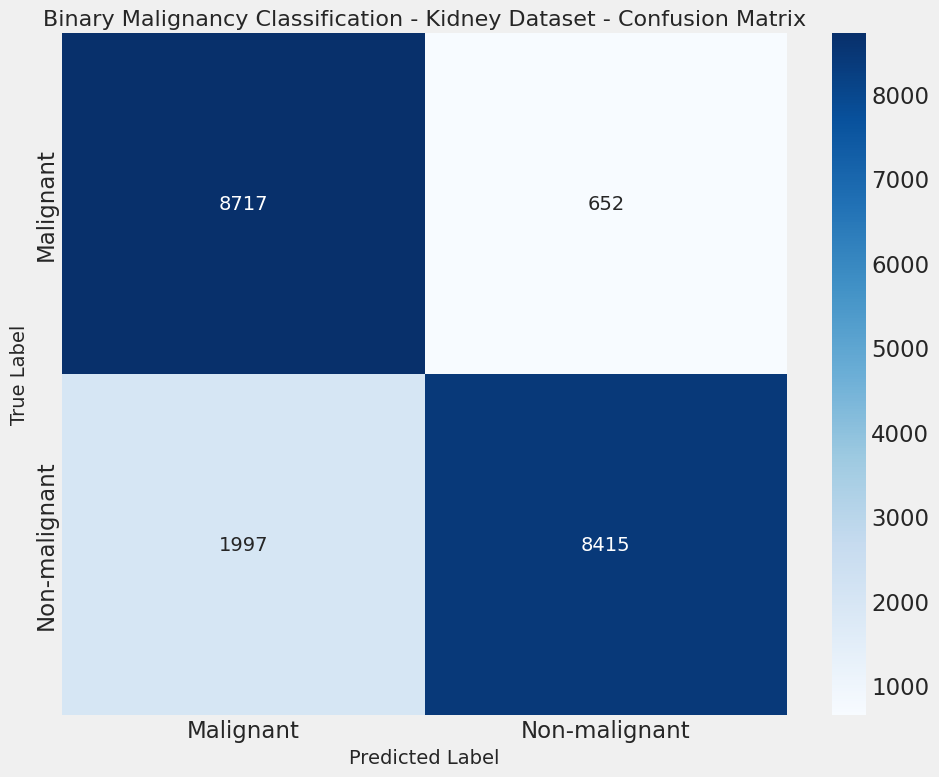

Confusion matrix plot saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/kidney_binary/model_outputs/kidney_binary_malignancy_confusion_matrix.png

SUMMARY
✅ Accuracy: 0.8661 (matches ensemble evaluation)
✅ F1-Score (Malignant): 0.8681
✅ F1-Score (Weighted Avg): 0.8659

Dataset: Kidney Cancer with Cell Types
Total cells: 19781
Malignant cells: 9369
Non-malignant cells: 10412
Malignant proportion: 47.4%


<Figure size 640x480 with 0 Axes>

In [21]:
# Complete Classification Report using Ensemble Data for Kidney Malignancy
print("="*60)
print("COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT - KIDNEY DATASET")
print("="*60)

# Print full classification report
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)

# Calculate all metrics using ensemble data
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=0,  # 0 = Malignant (based on label encoder)
                                                         zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Malignant Precision: {precision:.4f}")
print(f"Malignant Recall: {recall:.4f}")
print(f"Malignant F1-Score: {f1:.4f}")

# Per-class metrics
print("\nPer-class metrics:")
class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
    ensemble_true_labels, ensemble_predictions, average=None, zero_division=0
)

print(f"Malignant (class 0) - Precision: {class_precision[0]:.4f}, Recall: {class_recall[0]:.4f}, F1: {class_f1[0]:.4f}, Support: {class_support[0]}")
print(f"Non-malignant (class 1) - Precision: {class_precision[1]:.4f}, Recall: {class_recall[1]:.4f}, F1: {class_f1[1]:.4f}, Support: {class_support[1]}")

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Confusion matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predictions)
print("Raw confusion matrix:")
print(cm)

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Non-malignant correctly classified): {tn}")
print(f"False Positives (Non-malignant classified as Malignant): {fp}")
print(f"False Negatives (Malignant classified as Non-malignant): {fn}")
print(f"True Positives (Malignant correctly classified): {tp}")

# Additional metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nSensitivity (True Positive Rate for Malignant): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate for Non-malignant): {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant', 'Non-malignant'],
            yticklabels=['Malignant', 'Non-malignant'])
plt.title('Binary Malignancy Classification - Kidney Dataset - Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Save the plot with kidney dataset name
cm_plot_path = MODEL_OUT / 'kidney_binary_malignancy_confusion_matrix.png'
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix plot saved to: {cm_plot_path}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Accuracy: {accuracy:.4f} (matches ensemble evaluation)")
print(f"✅ F1-Score (Malignant): {f1:.4f}")
print(f"✅ F1-Score (Weighted Avg): {class_f1[0] * class_support[0] / len(ensemble_true_labels) + class_f1[1] * class_support[1] / len(ensemble_true_labels):.4f}")

# Additional kidney dataset specific info
print(f"\nDataset: Kidney Cancer with Cell Types")
print(f"Total cells: {len(ensemble_true_labels)}")
print(f"Malignant cells: {class_support[0]}")
print(f"Non-malignant cells: {class_support[1]}")
print(f"Malignant proportion: {class_support[0] / len(ensemble_true_labels) * 100:.1f}%")